# **Mount Data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load Model (if need to continue training)**

In [2]:
from keras.models import load_model

model_fullpath = "/content/drive/My Drive/vgg16_3class_acc87"
model_final = load_model(model_fullpath)

Using TensorFlow backend.


# **Imports and Configs**

In [0]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop, SGD
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
import numpy as np
import datetime

train_data_dir = "/content/drive/My Drive/CAD Project/dataset2/train"
validation_data_dir = "/content/drive/My Drive/CAD Project/dataset2/val"

img_width, img_height = 150, 150

batch_size = 64

# since the classes are unbalanced, add some weighted penalty during training
classWeight={
    0: 1.0/400,
    1: 1.0/800,
    2: 1.0/800
}

# **Prepare Data**

In [0]:
# Initiate the train without data Augumentation 
train_generator = ImageDataGenerator().flow_from_directory(
  train_data_dir,
  target_size = (img_height, img_width),
  batch_size = batch_size, 
  class_mode = "categorical"
)

# Initiate the train with data Augumentation
train_generator_augment = ImageDataGenerator(
  horizontal_flip = True,
  fill_mode = "nearest",
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range=0.1,
  rotation_range=180
).flow_from_directory(
  train_data_dir,
  target_size = (img_height, img_width),
  batch_size = batch_size, 
  class_mode = "categorical"
)

# Initiate the validation
validation_generator = ImageDataGenerator().flow_from_directory(
  validation_data_dir,
  target_size = (img_height, img_width),
  batch_size=batch_size,
  class_mode = "categorical"
)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples 

# **Build Model**

In [4]:
# Load the pretrained VGG16 model without the classification/dense layers
model = applications.VGG16(weights = "imagenet", include_top=False, 
                           input_shape = (img_width, img_height, 3))


# Freeze all the layers
for layer in model.layers:
    layer.trainable = False

# Adding custom Layers 
x = model.output
x = Flatten()(x)

x = Dense(1024, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Dense(1024, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

predictions = Dense(3, activation='softmax')(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.001),
              metrics=['acc'])



Found 2000 images belonging to 3 classes.
Found 2000 images belonging to 3 classes.
Found 500 images belonging to 3 classes.


In [12]:
# model_final.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

# **Train**

In [0]:
history = model_final.fit_generator(
      train_generator_augment,
      steps_per_epoch=nb_train_samples/batch_size, 
      epochs=100,
      class_weight = classWeight,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples/batch_size,
      verbose=2
)

Epoch 1/100
 - 45s - loss: 0.0030 - acc: 0.4781 - val_loss: 1.4706 - val_acc: 0.5640
Epoch 2/100
 - 41s - loss: 0.0018 - acc: 0.5553 - val_loss: 2.1496 - val_acc: 0.4960
Epoch 3/100
 - 41s - loss: 0.0015 - acc: 0.5850 - val_loss: 1.4333 - val_acc: 0.5840
Epoch 4/100
 - 41s - loss: 0.0014 - acc: 0.6065 - val_loss: 2.4166 - val_acc: 0.5700
Epoch 5/100
 - 41s - loss: 0.0013 - acc: 0.6299 - val_loss: 1.5317 - val_acc: 0.5900
Epoch 6/100
 - 41s - loss: 0.0013 - acc: 0.6328 - val_loss: 1.1467 - val_acc: 0.6600
Epoch 7/100
 - 41s - loss: 0.0011 - acc: 0.6620 - val_loss: 1.4905 - val_acc: 0.6480
Epoch 8/100
 - 41s - loss: 0.0011 - acc: 0.6665 - val_loss: 1.4888 - val_acc: 0.5980
Epoch 9/100
 - 41s - loss: 0.0011 - acc: 0.6830 - val_loss: 1.9264 - val_acc: 0.6120
Epoch 10/100
 - 41s - loss: 0.0011 - acc: 0.6791 - val_loss: 1.0278 - val_acc: 0.6460
Epoch 11/100
 - 41s - loss: 0.0011 - acc: 0.6720 - val_loss: 1.2858 - val_acc: 0.6240
Epoch 12/100
 - 41s - loss: 0.0011 - acc: 0.6837 - val_loss: 1.

In [0]:
history = model_final.fit_generator(
      train_generator,
      steps_per_epoch=nb_train_samples/batch_size, 
      epochs=10,
      class_weight = classWeight,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples/batch_size,
      verbose=2
)

Epoch 1/10
 - 33s - loss: 4.6665e-04 - acc: 0.8622 - val_loss: 0.7845 - val_acc: 0.7400
Epoch 2/10
 - 30s - loss: 2.9816e-04 - acc: 0.9164 - val_loss: 0.8865 - val_acc: 0.7200
Epoch 3/10
 - 30s - loss: 1.8742e-04 - acc: 0.9463 - val_loss: 0.9244 - val_acc: 0.7320
Epoch 4/10
 - 30s - loss: 1.0040e-04 - acc: 0.9751 - val_loss: 1.4323 - val_acc: 0.6800
Epoch 5/10
 - 31s - loss: 8.2505e-05 - acc: 0.9805 - val_loss: 0.9775 - val_acc: 0.7220
Epoch 6/10
 - 30s - loss: 4.3411e-05 - acc: 0.9897 - val_loss: 1.3337 - val_acc: 0.7140
Epoch 7/10
 - 30s - loss: 7.8399e-05 - acc: 0.9865 - val_loss: 1.5830 - val_acc: 0.7060
Epoch 8/10
 - 30s - loss: 2.3054e-05 - acc: 0.9942 - val_loss: 1.4421 - val_acc: 0.7020
Epoch 9/10
 - 30s - loss: 4.9612e-05 - acc: 0.9908 - val_loss: 1.4312 - val_acc: 0.6960
Epoch 10/10
 - 30s - loss: 3.3667e-05 - acc: 0.9937 - val_loss: 1.3240 - val_acc: 0.7140


# **Fine Tune**

In [0]:
# all layers are trainable
for layer in model.layers:
    layer.trainable = True
    
model_final.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.RMSprop(lr=0.0001),
#               optimizer=optimizers.SGD(lr=0.0001, momentum=0.5),
              optimizer=optimizers.Adam(lr=0.0001, decay=0.05),
              metrics=['acc'])


history = model_final.fit_generator(
      train_generator_augment,
      steps_per_epoch=nb_train_samples/batch_size, 
      epochs=100,
      class_weight = classWeight,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples/batch_size,
      verbose=2
)

Epoch 1/100
 - 54s - loss: 5.6636e-04 - acc: 0.8335 - val_loss: 1.0978 - val_acc: 0.6200
Epoch 2/100
 - 46s - loss: 5.0631e-04 - acc: 0.8476 - val_loss: 0.3615 - val_acc: 0.8640
Epoch 3/100
 - 46s - loss: 4.5152e-04 - acc: 0.8677 - val_loss: 2.0838 - val_acc: 0.5400
Epoch 4/100
 - 46s - loss: 6.7618e-04 - acc: 0.7993 - val_loss: 5.0064 - val_acc: 0.4200
Epoch 5/100
 - 46s - loss: 6.3285e-04 - acc: 0.8203 - val_loss: 2.4553 - val_acc: 0.4280
Epoch 6/100
 - 46s - loss: 6.0770e-04 - acc: 0.8125 - val_loss: 1.1060 - val_acc: 0.6260
Epoch 7/100
 - 46s - loss: 5.3806e-04 - acc: 0.8394 - val_loss: 0.6708 - val_acc: 0.7260
Epoch 8/100
 - 46s - loss: 4.9963e-04 - acc: 0.8526 - val_loss: 0.5491 - val_acc: 0.8000
Epoch 9/100
 - 46s - loss: 4.5728e-04 - acc: 0.8599 - val_loss: 0.4469 - val_acc: 0.8280
Epoch 10/100
 - 46s - loss: 4.9224e-04 - acc: 0.8482 - val_loss: 0.4177 - val_acc: 0.8400
Epoch 11/100
 - 46s - loss: 4.7669e-04 - acc: 0.8574 - val_loss: 0.4425 - val_acc: 0.8380
Epoch 12/100
 - 46s

KeyboardInterrupt: ignored

# **Predict**

In [5]:
from keras.utils.np_utils import to_categorical

test_datagenerator = ImageDataGenerator()

test_generator = test_datagenerator.flow_from_directory(
  validation_data_dir,
  target_size = (img_height, img_width),
  class_mode = "categorical",
  batch_size = batch_size,
  shuffle=False
)

# test_generator.reset()
probabilities = model_final.predict_generator(test_generator,steps=500/batch_size)

y_pred_ravel = np.argmax(probabilities, axis=-1)
y_true_ravel = np.array([0] * 100 + [1] * 200 + [2] * 200)


# Make into categorical
y_pred_cat = to_categorical(y_pred_ravel, num_classes=3)
y_true_cat = to_categorical(y_true_ravel, num_classes=3)

# from keras import backend
# y_true_cat =  backend.one_hot(y_true_cat, 3)
# y_pred_cat = backend.one_hot(probabilities, 3)

# label_map = (train_generator.class_indices)
# label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
# predictions = [label_map[k] for k in predictions]

Found 500 images belonging to 3 classes.


# **Accuracy**

In [10]:
res = y_true_ravel == y_pred_ravel

print(np.sum(res)/len(res))

0.866


Text(0.5,1,'Training (blue) and validation (green) loss')

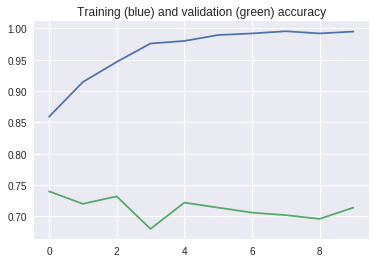

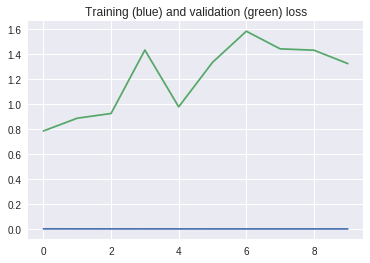

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training (blue) and validation (green) accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training (blue) and validation (green) loss')

# **Confusion Matrix**

Confusion matrix, without normalization
[[ 86   9   5]
 [  6 176  18]
 [  5  24 171]]
Normalized confusion matrix
[[0.86 0.09 0.05]
 [0.03 0.88 0.09]
 [0.03 0.12 0.85]]


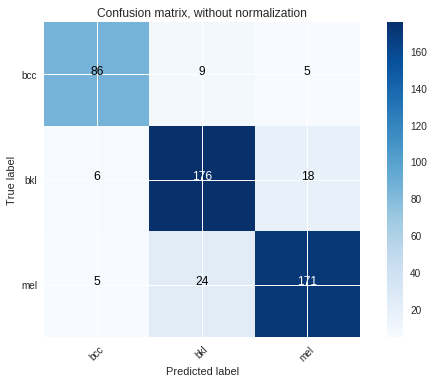

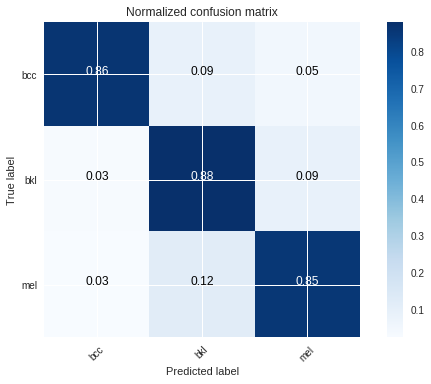

In [7]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ['bcc', 'bkl', 'mel']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true_ravel, y_pred_ravel)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# **Confusion Matrix**

In [8]:
from sklearn.metrics import classification_report

print(classification_report(y_true_ravel, y_pred_ravel))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87       100
           1       0.84      0.88      0.86       200
           2       0.88      0.85      0.87       200

   micro avg       0.87      0.87      0.87       500
   macro avg       0.87      0.86      0.87       500
weighted avg       0.87      0.87      0.87       500



# **AUC**

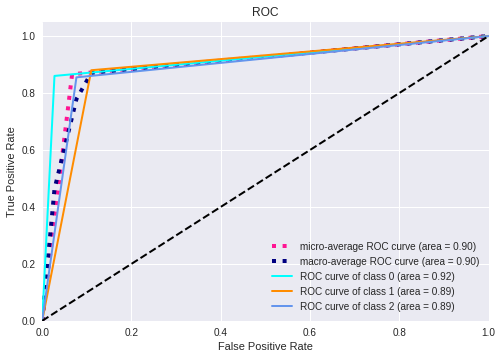

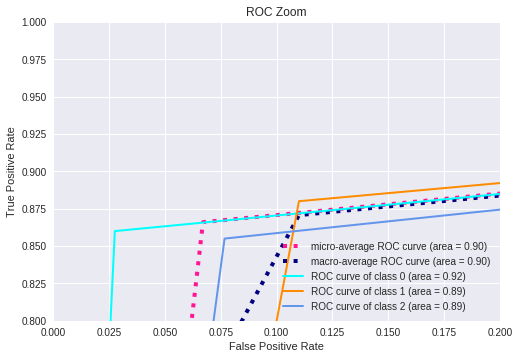

In [11]:
# https://hackernoon.com/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier-2ecc6c73115a

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

n_classes = 3

# Plot linewidth.
lw = 2

# y_true = to_categorical(np.array([1,1,0,2]), num_classes=3)
# y_pred = to_categorical(np.array([0,1,0,2]), num_classes=3)

y_test = y_true_cat
y_score = y_pred_cat

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Zoom')
plt.legend(loc="lower right")
plt.show()

# **Save Model**

In [0]:
model_final.save(modelName)

# from google.colab import files
# files.download(modelName) 

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory   
model_file = drive.CreateFile({'title' : modelName})
model_file.SetContentFile(modelName)
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1VJZV0zej6Z_9IyJHTQnIVvimzevGKFUc'})